# BitTrack Project
## Send request and Get data

In [1]:
import requests
import csv
import json

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

# Time in UNIX format
month = 2629743
now = int(time.time())
start_time = now - 3*month
DATALENGTH = 500
ema_length = 50

url = f"http://api.coincap.io/v2/assets/bitcoin/history?interval=m1"
print(url)

# Request data from the API
response = requests.request("GET", url, headers={}, data={})
json_data = json.loads(response.text.encode('utf8'))
# print(json_data)
bitcoin_data = json_data["data"]

df = pd.DataFrame(bitcoin_data)
## Export data as a csv file
# df.to_csv('BTCUSD.csv', index=False)
print(df.sample)
# df.dtypes

# Filter only the columns we need
df = pd.DataFrame(bitcoin_data, columns=['time', 'priceUsd'])
# Get last 200 rows and REVERSE, newest price on top (index 0)
df = df[:-DATALENGTH-1:-1]
print(df.sample)

# Convert 'priceUsd' datatype to something numeric
df['priceUsd'] = pd.to_numeric(df['priceUsd'], errors='coerce', downcast='integer').fillna(0, downcast='infer')
df.dtypes
df.info()

http://api.coincap.io/v2/assets/bitcoin/history?interval=m1
<bound method NDFrame.sample of                     priceUsd           time          circulatingSupply  \
0     31458.3555108265116399  1626490020000  18743737.0000000000000000   
1     31447.2481063092130517  1626490080000  18743737.0000000000000000   
2     31457.7917821816837452  1626490140000  18743737.0000000000000000   
3     31445.1559847649107996  1626490200000  18743737.0000000000000000   
4     31419.9035088566593198  1626490260000  18743737.0000000000000000   
...                      ...            ...                        ...   
1435  32180.3034251488883934  1626576120000  18743737.0000000000000000   
1436  32195.3079651272566012  1626576180000  18743737.0000000000000000   
1437  32187.7824070572181464  1626576240000  18743737.0000000000000000   
1438  32187.9258329292506710  1626576300000  18743737.0000000000000000   
1439  32176.1912989210639317  1626576360000  18743737.0000000000000000   

                   

In [2]:
# Check data 
prices = df['priceUsd']
print(prices)

1439    32176.191299
1438    32187.925833
1437    32187.782407
1436    32195.307965
1435    32180.303425
            ...     
944     31805.613269
943     31812.035257
942     31800.143544
941     31801.104331
940     31800.589439
Name: priceUsd, Length: 500, dtype: float64


In [3]:
# Calculate and check last ema value 
count = 0
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

In [4]:
print("EMA50 H1:", ema(df['priceUsd'], count))

EMA50 H1: 32214.80675366795


In [5]:
# Process UNIX time to readable form
timeStamp =  df['time'].values.tolist()
timeStamp = [x / 1000 for x in timeStamp]

In [6]:
# Insert readable timeStamp column to 'df'
df['timeStamp'] = pd.to_datetime(timeStamp, unit='s')

In [7]:
# Check
df.sample

<bound method NDFrame.sample of                time      priceUsd           timeStamp
1439  1626576360000  32176.191299 2021-07-18 02:46:00
1438  1626576300000  32187.925833 2021-07-18 02:45:00
1437  1626576240000  32187.782407 2021-07-18 02:44:00
1436  1626576180000  32195.307965 2021-07-18 02:43:00
1435  1626576120000  32180.303425 2021-07-18 02:42:00
...             ...           ...                 ...
944   1626546660000  31805.613269 2021-07-17 18:31:00
943   1626546600000  31812.035257 2021-07-17 18:30:00
942   1626546540000  31800.143544 2021-07-17 18:29:00
941   1626546480000  31801.104331 2021-07-17 18:28:00
940   1626546420000  31800.589439 2021-07-17 18:27:00

[500 rows x 3 columns]>

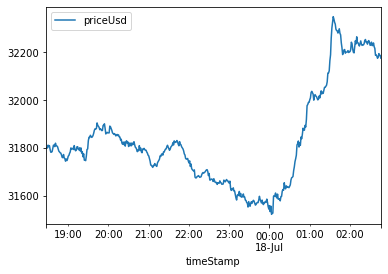

In [8]:
# Plot the data
df.plot(x ='timeStamp', y='priceUsd', kind = 'line')
plot.show()

## Calculate the possible EMA for each timeStamp
'possible' means timeStamp that have at lease 50 values before it. After that, we add EMA value along with the above figure.

In [9]:
short_df = df.head(DATALENGTH-ema_length)
short_df.reset_index()

,index,time,priceUsd,timeStamp
0,1439,1626576360000,32176.191299,2021-07-18 02:46:00
1,1438,1626576300000,32187.925833,2021-07-18 02:45:00
2,1437,1626576240000,32187.782407,2021-07-18 02:44:00
3,1436,1626576180000,32195.307965,2021-07-18 02:43:00
4,1435,1626576120000,32180.303425,2021-07-18 02:42:00
...,...,...,...,...
445,994,1626549660000,31784.720039,2021-07-17 19:21:00
446,993,1626549600000,31779.176077,2021-07-17 19:20:00
447,992,1626549540000,31800.428558,2021-07-17 19:19:00
448,991,1626549480000,31787.641691,2021-07-17 19:18:00


In [10]:
short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))

<ipython-input-10-b2c0fb1e9939>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))


In [11]:
# short_df['N'] = np.arange(len(short_df))
short_df.insert(loc=0, column='N', value=np.arange(len(short_df)))

In [12]:
# Try modifying a value in EMA column
short_df.loc[713,'EMA'] = 999999
# Try accessing short_df
print(short_df['EMA'].iloc[-1])

999999.0
<ipython-input-12-f518db29354b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df.loc[713,'EMA'] = 999999


In [13]:
# Finalize 'ema' function to run in for loop
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

# Calculate ema values and replace them into the dataframe
for i in range(0, DATALENGTH-ema_length):
    count = 0
    # short_df.iloc[ ?,4 ] => 'EMA' column
    short_df.iloc[ i,4 ] = ema( df['priceUsd'].iloc[ i: ], count )


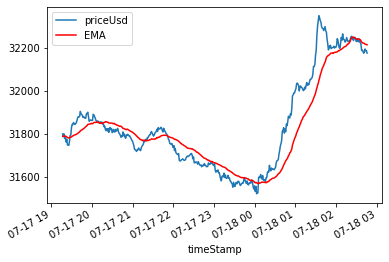

In [14]:
# Reference article https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
ax = plot.gca()
short_df.plot(kind='line',x='timeStamp',y='priceUsd', ax=ax)
short_df.plot(kind='line',x='timeStamp',y='EMA', color='red', ax=ax)
plot.show()

## Create a while loop to update price constantly

## Alarm when PRICE cross EMA

## Analyze profit/loss if trade base on EMA 
using data in the past 1 year  
with R:R=1:1, TP = SL = 5%  
TP 80% when reach target, move SL to entry

